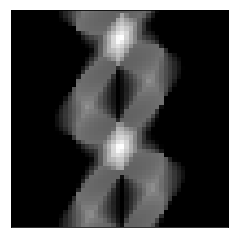

kernel singoram convolve:
[0.0, -0.04503163717437234, 0.0, -0.4052847345693511, 1.0, -0.4052847345693511, 0.0, -0.04503163717437234, 0.0]


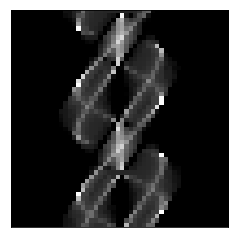

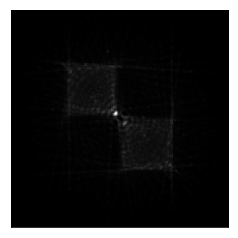

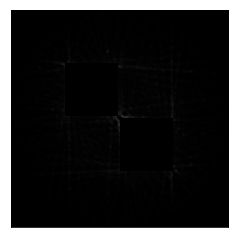

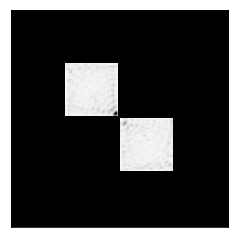

19707.568807


In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math as m
import dicom, dicom.UID
from dicom.dataset import Dataset, FileDataset
import datetime, time
from IPython.display import clear_output
import copy


def load(name):
    im = cv2.imread(name)
    return im

def plot(img):
#     tmp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    tmp = img
    plt.imshow(tmp)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
def colorMean(color):
    return (0.11 * color[0] + 0.59 * color[1] + 0.3 * color[2])

def brightColor(color, brightness):
    color += brightness
    return color
    
def BresenhamLine(img, x1, y1, x2, y2, M):
    x = x1
    y = y1
    sum = 0
    it = 0
    
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
        
    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2
        
    col = colorMean(img[x][y])
    sum += col
    M[x][y] += 1
    it += 1
        
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi  
                
            col = colorMean(img[x][y])
            sum += col
            M[x][y] += 1
            it += 1
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
                
            col = colorMean(img[x][y])
            sum += col
            M[x][y] += 1
            it += 1
            
    return (sum / it)
#     return sum / (img.shape[0] - 10)
    
def findMax(sinog):
    maks = 0
    for row in sinog:
        for el in row:
            if el > maks:
                maks = el
    return maks
    
def normalize(sinog):
    maks = findMax(sinog)
    for i, row in enumerate(sinog):
        for j, el in enumerate(row):
            if maks != 0:
                sinog[i][j] = sinog[i][j] / maks * 255
    return sinog

def cutMinus(img):
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            if el < 0:
                img[i][j] = 0
    return img

def findMin(img):
    min = 1000000
    for row in img:
        for el in row:
            if el < min:
                min = el
    return min

def setImgToMinZero(img):
    mmin = findMin(img)
    for i, row in enumerate(img):
        for j, el in enumerate(img):
            img[i][j] = img[i][j] - mmin
    return img

def mapBlackPoints(img):
    imgNew = []
    for i in range(width):
        imgNew.append([])
        for j in range(width):
            imgNew[i].append(0) 
            
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            if img[i][j] == 0:
                imgNew[i][j] = 1
                
    return imgNew

def putBlackMapOn(mapBlack, img):
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            if mapBlack[i][j] == 1:
                img[i][j] = 0.0

def convertToUint8RGB(img):
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            el = np.uint8(round(el))
            img[i][j] = [el, el, el]
    
    return img;

def convertToDicomImg(img, height, width):
    img2 = []
    for i in range(height):
        img2.append([])
        for j in range(width):
            img2[i].append(np.uint16(0))
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            el = np.uint16(round(el))
            img2[i][j] = el
    return img2

def convolveSinogram(img, kernelSize=9):
    width = len(img)
    imgNew = []
    for i in range(width):
        imgNew.append([])
        for j in range(width):
            imgNew[i].append(0.0) 
            
    kernelCenter = (int)(kernelSize / 2)
    kernel = []
    for i in range(kernelSize):
        if i == kernelCenter:
            kernel.append(1.0)
        elif i % 2 == 0:
            kernel.append(0.0)
        else:
            kernel.append((-4 / pow(m.pi, 2)) / pow(i - kernelCenter, 2))
            
    print("kernel singoram convolve:")
    print(kernel)
            
    width = len(img[0])
    for i, row in enumerate(img):
        j = kernelCenter
        while j < (width - kernelCenter):
            it = 0
            k = j - kernelCenter
            while it < kernelSize:
                imgNew[i][j] += img[i][k] * kernel[it]
                k += 1
                it += 1
            j += 1
        
    return imgNew

def sinogram(img, M, steps=12, l=45, detectors=5, alfa=180, iterations=0): 
    if iterations == 0:
        iterations = steps
    alfa = alfa / steps
    alfaRadians = m.radians(alfa)
    center = (int)(img.shape[0] / 2)
    radius = center - 5 
    centerTuple = (center, center)
#     cv2.circle(img, centerTuple, radius, (255,255,255))
#     plot(img)
    tmpRadians = 0
    sinog = []
    for i in range(iterations):
        sinog.append([])
    
    for i in range(iterations):
        x = center + int(radius * np.cos(tmpRadians))
        y = center + int(radius * np.sin(tmpRadians))
#         cv2.circle(img, (x,y), 5, (0,255,255), -1)
        tmpDetectorRadians = m.radians(180 - l/2) + tmpRadians
#         print(tmpDetectorRadians)
        detectorStep = m.radians(l / (detectors - 1))
        for j in range(detectors):
            xDet = center + int(radius * np.cos(tmpDetectorRadians))
            yDet = center + int(radius * np.sin(tmpDetectorRadians))
            tmpDetectorRadians += detectorStep
#             cv2.circle(img, (xDet,yDet), 5, (0,255-col,col), -1)
            sinog[i].append(BresenhamLine(img, x, y, xDet, yDet, M))
            
        tmpRadians += alfaRadians
        
        clear_output(wait=True)
        sinog2 = copy.deepcopy(sinog[:(i+1)])
        sinog2 = normalize(sinog2)
        sinog2 = convertToUint8RGB(sinog2)
        sinog2 = np.asarray(sinog2)
        plot(sinog2)

#     sinog = normalize(sinog)
#     mapBlack = mapBlackPoints(sinog)
    sinog = convolveSinogram(sinog)
    sinog = cutMinus(sinog)
#     sinog = setImgToMinZero(sinog)
#     putBlackMapOn(mapBlack, sinog)
    sinog = normalize(sinog)

    sinog = convertToUint8RGB(sinog)
    sinog = np.asarray(sinog)
    plot(sinog)
    
    return sinog


def BresenhamLineInverse(img, x1, y1, x2, y2, brightness):
    x = x1
    y = y1
    
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
        
    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2
        
    # pierwszy punkt
    img[x][y] = brightColor(img[x][y], brightness)
        
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi  
                
            #pozostale punkty
            img[x][y] = brightColor(img[x][y], brightness)
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
                
            #pozostale punkty
            img[x][y] = brightColor(img[x][y], brightness)
            
    return img
    
def convolve(img, kernelSize):
    width = len(img)
    imgNew = []
    for i in range(width):
        imgNew.append([])
        for j in range(width):
            imgNew[i].append(0.0) 
            
    kernel = np.ones((kernelSize, kernelSize))
    kernel /= 1.0 * kernelSize * kernelSize
    
    shift = (int)((kernelSize-1) / 2)
    m = shift
    while m < (width - shift):
        n = shift
        while n < (width - shift):
            i = m - shift
            while i <= (m + shift):
                j = n - shift
                while j <= (n + shift):
                    imgNew[m][n] += img[i][j] * kernel[m-i][n-j]
                    j += 1
                i += 1
            n += 1
        m += 1
    return imgNew
    
def inverseRadonTransform(img, M, sinog, steps, l, detectors, alfa, kernelSize = 5, iterations=0):
    if iterations == 0:
        iterations = steps
    alfa = alfa / steps
    alfaRadians = m.radians(alfa)
    center = (int)(img.shape[0] / 2)
    radius = center - 5 
    centerTuple = (center, center)
    
    height, width, channels = img.shape
    img2 = []
    for i in range(height):
        img2.append([])
        for j in range(width):
            img2[i].append(np.uint16(0))

    tmpRadians = 0
    
    for i in range(iterations):
        x = center + int(radius * np.cos(tmpRadians))
        y = center + int(radius * np.sin(tmpRadians))
        tmpDetectorRadians = m.radians(180 - l/2) + tmpRadians
        detectorStep = m.radians(l / (detectors - 1))
        for j in range(detectors):
            xDet = center + int(radius * np.cos(tmpDetectorRadians))
            yDet = center + int(radius * np.sin(tmpDetectorRadians))
            tmpDetectorRadians += detectorStep
            brightness = colorMean(sinog[i][j])
            img2 = BresenhamLineInverse(img2, x, y, xDet, yDet, brightness)

        tmpRadians += alfaRadians
        
    for i, row in enumerate(img2):
        for j, el in enumerate(row):
#             ver2
            if M[i][j] != 0:
                img2[i][j] = el / M[i][j]
    
    img2 = normalize(img2)
    
    for i, row in enumerate(img2):
        for j, el in enumerate(row):
            img2[i][j] = m.pow(el, 2)
            
    img2 = convolve(img2, kernelSize)
    
    for i, row in enumerate(img2):
        for j, el in enumerate(row):
            img2[i][j] = m.pow(el, (3/2))
    
    img2 = normalize(img2)
    dicomImg = convertToDicomImg(img2, height, width)
    img2 = convertToUint8RGB(img2)
    img2 = np.asarray(img2)
    dicomImg = np.asarray(dicomImg)
    return img2, dicomImg

def write_dicom(filename, pixel_array):
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = 'Secondary Capture Image Storage'
    file_meta.MediaStorageSOPInstanceUID = '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    file_meta.ImplementationClassUID = '1.3.6.1.4.1.9590.100.1.0.100.4.0'
    ds = FileDataset(filename, {},file_meta = file_meta,preamble=b"\0" * 128)
    
    # Add the data elements -- not trying to set all required here. Check DICOM standard
    ds.PatientName = "Agnieszka Lipska"
    ds.PatientID = "123456"
    ds.PatientComments = "Komentarz"

    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.HighBit = 15
    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.Columns = pixel_array.shape[0]
    ds.Rows = pixel_array.shape[1]
    if pixel_array.dtype != np.uint16:
        pixel_array = pixel_array.astype(np.uint16)
    ds.PixelData = pixel_array.tostring()
    # Set creation date/time
    ds.ContentDate = str(datetime.date.today()).replace('-','')
    ds.ContentTime = str(time.time())
    ds.save_as(filename)

    
def MeanSquaredError(img, img2):
    err = np.sum((img.astype("float") - img2.astype("float")) ** 2)
    err /= float(img.shape[0] * img.shape[1])
    return err

def PictureDifference(img, img2, height, width): #ten co wyszedł odjąć pierwotny
    imgD = []
    for i in range(height):
        imgD.append([])
        for j in range(width):
            imgD[i].append(np.uint16(0))
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            imgD[i][j] = img2[i][j] - img[i][j]
            if img2[i][j][0]<img[i][j][0]:
                imgD[i][j] = img2[i][j] - img2[i][j]
    imgD = np.asarray(imgD)
    return imgD

def PictureDifference2(img, img2, height, width): #pierwotny odjąć ten co wyszedł
    imgD = []
    for i in range(height):
        imgD.append([])
        for j in range(width):
            imgD[i].append(np.uint16(0))
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            imgD[i][j] = img[i][j] - img2[i][j]
            if img[i][j][0]<img2[i][j][0]:
                imgD[i][j] = img[i][j] - img[i][j]
    imgD = np.asarray(imgD)
    return imgD

alfa = 360
steps = 50
l = 300
detectors = 50
kernelSize = 5
img = load("kwadraty2.bmp")
plot(img)

width, height, channels = img.shape
M = []
for i in range(width):
    M.append([])
    for j in range(height):
        M[i].append(0)
        
sinog = sinogram(img, M, steps, l, detectors, alfa)
newImg, dicomImg = inverseRadonTransform(img, M, sinog, steps, l, detectors, alfa, kernelSize)
plot(newImg)
write_dicom("test.dcm", dicomImg)
err = MeanSquaredError(img, newImg)
imgD = PictureDifference(img, newImg, height, width)
plot(imgD)
imgD = PictureDifference2(img, newImg, height, width)
plot(imgD)
print(err)